In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 29.2MB/s 
     |████████████████████████████████| 1.1MB 50.4MB/s 
     |████████████████████████████████| 890kB 53.4MB/s 


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=30cdd0fd7668eaa5d21e694b2b660fe5da276c01ffa9b056971f76e2d00ab9ef
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

import seaborn as sns
import matplotlib.pyplot as plt

import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

from collections import defaultdict
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

transformers.__version__

'3.5.1'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)


'Tesla T4'

In [ ]:
# function to load data

def get_params(sentences_file, labels_file):
    sentences = []
    labels = []

    with open(sentences_file) as f:
        for sentence in f.read().splitlines():
            # # replace each token by its index if it is in vocab
            # # else use index of UNK_WORD
            # s = [vocab[token] if token in vocab 
            #      else vocab['UNK']
            #      for token in sentence.split(' ')]
            sentence = sentence.split(' ')
            sentences.append(sentence)

    with open(labels_file) as f:
        for label in f.read().splitlines():
            # # replace each label by its index
            # l = [tag_map[label] for label in sentence.split(' ')] # I added plus 1 here
            label = label.split(' ')
            labels.append(label) 
    return sentences, labels, len(sentences)


In [ ]:
# Load training/validation/test data
path1 = "/content/drive/My Drive/NER Training data/sentences.txt"
path2 = "/content/drive/My Drive/NER Training data/labels.txt"

train_sentences, train_labels, train_len = get_params(path1,path2)

path1 = "/content/drive/My Drive/NER Validation data/sentences.txt"
path2 = "/content/drive/My Drive/NER Validation data/labels.txt"

valid_sentences, valid_labels, valid_len = get_params(path1,path2)

path1 = "/content/drive/My Drive/NER Test data/sentences.txt"
path2 = "/content/drive/My Drive/NER Test data/labels.txt"

test_sentences, test_labels, test_len = get_params(path1,path2)



In [ ]:
# Create a dictionary for tags

path = "/content/drive/My Drive/NER Training data/tags.txt"

tag_map = {}
with open(path) as f:
  for i, t in enumerate(f.read().splitlines()):
    tag_map[t] = i+1


In [ ]:
tag_map

{'B-art': 9,
 'B-eve': 15,
 'B-geo': 2,
 'B-gpe': 3,
 'B-nat': 14,
 'B-org': 6,
 'B-per': 4,
 'B-tim': 8,
 'I-art': 10,
 'I-eve': 16,
 'I-geo': 5,
 'I-gpe': 12,
 'I-nat': 17,
 'I-org': 7,
 'I-per': 11,
 'I-tim': 13,
 'O': 1}

In [ ]:
print(train_sentences[2])
print(train_labels[2])

['They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
# Lets load pre-trained BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### For each sentence and label lets create tokens using above tokenizer

In [ ]:
def tokenize_sentence_label(sentence, labels):
  tokenized_sentence = ['[CLS]']
  tokenized_labels = ['[CLS]']

  for word, label in zip(sentence, labels):
    tokenized_word = tokenizer.tokenize(word)
    #BERT tokenizer is based on Wordpiece tokenizer. It will split tokens into subword tokens. 
    #For example ‘gunships’ will be split in the two tokens ‘guns’ and ‘##hips’. Below we are dealing with the issue of splitting our token-level labels to related subtokens.
    n_subwords = len(tokenized_word)                 

    tokenized_sentence.extend(tokenized_word)
    #Add same label to the new list of labels 'n_subwords' times
    tokenized_labels.extend([label] * n_subwords)

  tokenized_sentence.append('[SEP]')
  tokenized_labels.append('[SEP]')
  return tokenized_sentence, tokenized_labels


In [ ]:
# Adding [SEP] and [CLS] tags to tag_map dictionary. BERT uses 101 and 102 for these two tokens. So lets use same

tag_map['[CLS]'] = 18
tag_map['[SEP]'] = 19
tag_map['PAD'] = 0

tags = list(tag_map.keys())

tag_map_index = {j:i for i,j in tag_map.items()}


In [ ]:
# Applying above 'tokenize_sentence_label' fn to entire dataset

training_tokenized_texts_and_labels = [tokenize_sentence_label(sent, labs) for sent, labs in zip(train_sentences, train_labels)]
valid_tokenized_texts_and_labels = [tokenize_sentence_label(sent, labs) for sent, labs in zip(valid_sentences, valid_labels)]
test_tokenized_texts_and_labels = [tokenize_sentence_label(sent, labs) for sent, labs in zip(test_sentences, test_labels)]

In [ ]:
train_sentences = [token_label_pair[0] for token_label_pair in training_tokenized_texts_and_labels]
train_labels = [token_label_pair[1] for token_label_pair in training_tokenized_texts_and_labels]

valid_sentences = [token_label_pair[0] for token_label_pair in valid_tokenized_texts_and_labels]
valid_labels = [token_label_pair[1] for token_label_pair in valid_tokenized_texts_and_labels]

test_sentences = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]

In [ ]:
# train_sentences = [' '.join(i) for i in train_sentences]
# train_labels = [' '.join(i) for i in train_labels]

# valid_sentences = [' '.join(i) for i in valid_sentences]
# valid_labels = [' '.join(i) for i in valid_labels]

# test_sentences = [' '.join(i) for i in test_sentences]
# test_labels = [' '.join(i) for i in test_labels]

In [ ]:
# Create dataframes which we can use in future

df_train = pd.DataFrame({'sentences':train_sentences,'labels':train_labels})
df_valid = pd.DataFrame({'sentences':valid_sentences,'labels':valid_labels})
df_test = pd.DataFrame({'sentences':test_sentences,'labels':test_labels})


In [ ]:
df_train['sentences'].to_numpy()

array([list(['[CLS]', 'Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '[SEP]']),
       list(['[CLS]', 'Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banner', '##s', 'with', 'such', 'slogan', '##s', 'as', '"', 'Bush', 'Number', 'One', 'Terror', '##ist', '"', 'and', '"', 'Stop', 'the', 'Bomb', '##ings', '.', '"', '[SEP]']),
       list(['[CLS]', 'They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.', '[SEP]']),
       ...,
       list(['[CLS]', 'Il', '##ya', 'Ko', '##val', '##chuk', 'scored', 'four', 'goals', 'Sunday', 'with', 'two', 'in', 'each', 'of', 'the', 'first', 'two', 'periods', '.', '[SEP]']),
       list(['[CLS]', 'Russian', 'goaltender', 'E', '##v', '##gen', '##i', 'Na', '##bo

In [ ]:
df_train['sentences'].to_numpy()

array(['[CLS] Thousands of demons ##tra ##tors have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . [SEP]',
       '[CLS] Families of soldiers killed in the conflict joined the protesters who carried banner ##s with such slogan ##s as " Bush Number One Terror ##ist " and " Stop the Bomb ##ings . " [SEP]',
       '[CLS] They marched from the Houses of Parliament to a rally in Hyde Park . [SEP]',
       ...,
       '[CLS] Il ##ya Ko ##val ##chuk scored four goals Sunday with two in each of the first two periods . [SEP]',
       '[CLS] Russian goaltender E ##v ##gen ##i Na ##bo ##kov posted consecutive shut ##out victories over Sweden and Kazakhstan with 48 saves . [SEP]',
       '[CLS] Although he allowed one goal by Latvia , he faced only seven shots in two periods before being replaced by his back - up . [SEP]'],
      dtype=object)

In [ ]:
df_train['labels'].to_numpy()

array([list(['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', '[SEP]']),
       list(['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']),
       list(['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', '[SEP]']),
       ...,
       list(['[CLS]', 'B-per', 'B-per', 'I-per', 'I-per', 'I-per', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']),
       list(['[CLS]', 'B-gpe', 'O', 'B-per', 'B-per', 'B-per', 'B-per', 'I-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', '[SEP]']),
       list(['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


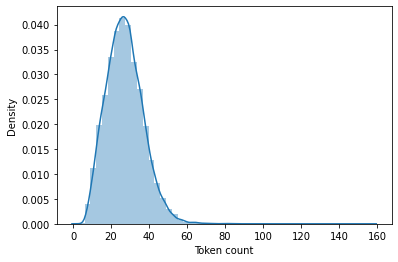

In [ ]:
# Choosing max sequence length since BERT works with fixed length sequences

token_lens = []

for txt in train_sentences:
  token_lens.append(len(txt))

# plot the distribution

sns.distplot(token_lens)
plt.xlabel('Token count');

In [ ]:
# 99.99% of sentences have length <= 60. So will choose max_length as 60
max_len = 60

In [ ]:
# # Now convert each token in to encoding. BERT uses 0 for padding so we also use same
# train_sentences_encoded = pad_sequences([tokenizer.convert_tokens_to_ids(train_sentence) for train_sentence in train_sentences], maxlen = max_len, value = 0, truncating='post',padding='post')
# train_labels_encoded = pad_sequences([[tag_map.get(l) for l in train_label] for train_label in train_labels], maxlen = max_len, value = 0, truncating='post',padding='post')

In [ ]:
# Now lets create PyTorch dataset from all above building blocks

class NERDataset(Dataset):
  def __init__(self, sentences, labels, tokenizer, tag_map, max_len):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.tag_map = tag_map
    self.max_len = max_len

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, item):
    sentence = self.sentences[item]
    label = self.labels[item]

    # encoding = self.tokenizer.encode_plus(
    #   tweet,
    #   add_special_tokens=True,
    #   max_length=self.max_len,
    #   truncation = True,
    #   return_token_type_ids=False,
    #   padding='max_length',
    #   return_attention_mask=True,
    #   return_tensors='pt',
    # )
    #sentences_encoded = pad_sequences([tokenizer.convert_tokens_to_ids(train_sentence) for train_sentence in train_sentences], maxlen = max_len, value = 0, truncating='post',padding='post')
    
    # sentence = sentence.split(' ')
    # label = label.split(' ')

    sentence_encoded = pad_sequences([self.tokenizer.convert_tokens_to_ids(sentence)], maxlen = self.max_len, value = 0, truncating='post',padding='post')[0]
    label_encoded = pad_sequences([[self.tag_map.get(l) for l in label]], maxlen = self.max_len, value = 0, truncating='post',padding='post')[0]

    # attention mask
    attention_mask = [float(i != 0.0) for i in sentence_encoded]


    return {
      'input_ids': sentence_encoded,
      'attention_mask': np.array(attention_mask),
      'targets': label_encoded
    }


In [ ]:
# Now lets create dataloaders for our train, validation and test data

def create_data_loader(df, tokenizer, tag_map, max_len, batch_size):
  ds = NERDataset(
    sentences=df['sentences'].to_numpy(),
    labels=df['labels'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
    tag_map=tag_map
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

batch_size = 16      # Bert recommendation

train_data_loader = create_data_loader(df_train, tokenizer, tag_map, max_len, batch_size)
valid_data_loader = create_data_loader(df_valid, tokenizer, tag_map, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, tag_map, max_len, batch_size)


In [ ]:
# Lets have a look at an example batch from our traning data

data = next(iter(train_data_loader))

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16, 60])


In [ ]:
# The transformer package provides a BertForTokenClassification class for token-level predictions. 
# BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag_map), output_attentions = False, output_hidden_states = False)
model.to(device)

NameError: ignored

In [ ]:
# BERT paper gave some recommendations on hyperparameters for fine tuning
# Batch size: 16, 32

# Adam learning rate: 5e-5, 3e-5, 2e-5

# Number of epochs: 2,3,4

# Will follow training procedure from BERT paper, will use AdamW optimizer from Hugging Face.

EPOCHS = 7

optimizer = AdamW(model.parameters(), lr = 3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# loss_fn = nn.CrossEntropyLoss().to(device)

## Training

In [ ]:
# Use F score as metric

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):

  model = model.train()
  losses = []
  predictions, true_labels = [], []

  for d in data_loader:
    input_ids = d["input_ids"].type(torch.LongTensor)
    attention_mask = d["attention_mask"].type(torch.LongTensor)
    targets = d["targets"].type(torch.LongTensor)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()
    # Since we provided labels, loss will be returned
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels = targets,
    )

    loss = outputs[0]
    
    # _, preds = torch.max(outputs, dim=1)                #Returns the max value of elements
    # loss = loss_fn(outputs, targets)
    # correct_predictions += torch.sum(preds == targets)
    # precision.update((outputs, targets))
    # recall.update((outputs, targets))

    
    loss.backward()
    losses.append(loss.item())
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = targets.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

  pred_tags = [tag_map_index.get(p_i) for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if tag_map_index.get(l_i) != "PAD" if tag_map_index.get(l_i) != "[CLS]" if tag_map_index.get(l_i) != "[SEP]"]
  train_tags = [tag_map_index.get(l_i) for l in true_labels for l_i in l if tag_map_index.get(l_i) != "PAD" if tag_map_index.get(l_i) != "[CLS]" if tag_map_index.get(l_i) != "[SEP]"]


  return accuracy_score(pred_tags,train_tags), np.mean(losses)

In [ ]:
# validation

def eval_model(model, data_loader, device, n_examples):
  model = model.eval()
  losses = []
  predictions, true_labels = [], []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].type(torch.LongTensor)
      attention_mask = d["attention_mask"].type(torch.LongTensor)
      targets = d["targets"].type(torch.LongTensor)

      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels = targets
      )

      # Move logits and labels to CPU
      logits = outputs[1].detach().cpu().numpy()
      label_ids = targets.to('cpu').numpy()

      loss = outputs[0]
      losses.append(loss.item())

      predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
      true_labels.extend(label_ids)

      # correct_predictions += torch.sum(preds == targets)

    pred_tags = [tag_map_index.get(p_i) for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if tag_map_index.get(l_i) != "PAD" if tag_map_index.get(l_i) != "[CLS]" if tag_map_index.get(l_i) != "[SEP]"]
    valid_tags = [tag_map_index.get(l_i) for l in true_labels for l_i in l if tag_map_index.get(l_i) != "PAD" if tag_map_index.get(l_i) != "[CLS]" if tag_map_index.get(l_i) != "[SEP]"]


  return accuracy_score(pred_tags,valid_tags), np.mean(losses)

In [ ]:
%%time
# Lets define our training loop using above two functions
# standard block
# used F2 score as metric here
history = defaultdict(list)

best_acc = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} Accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, valid_data_loader, device, len(df_valid))

  print(f'Val   loss {val_loss} Accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state_f4.bin')
    best_acc = val_acc

# We are storing state of best model indicated by highest validation f2 score



Epoch 1/7
----------
Train loss 0.19048863865080334 Accuracy 0.9438985029204393
Val   loss 0.12555314246979024 Accuracy 0.9564364918524377

Epoch 2/7
----------
Train loss 0.10581909507158256 Accuracy 0.96342480577661
Val   loss 0.11667962126847771 Accuracy 0.9595944617446274

Epoch 3/7
----------
Train loss 0.0803628679728579 Accuracy 0.9711618433737217
Val   loss 0.12572518319719367 Accuracy 0.9604292642204757

Epoch 4/7
----------
Train loss 0.061379296270066074 Accuracy 0.9777458272687749
Val   loss 0.13307341173291207 Accuracy 0.9614288303428732

Epoch 5/7
----------
Train loss 0.048201257089330325 Accuracy 0.9823686747443434
Val   loss 0.14385871404781939 Accuracy 0.9605171381653018

Epoch 6/7
----------
Train loss 0.038823820604454905 Accuracy 0.9858975388919343
Val   loss 0.1537818128367265 Accuracy 0.9605995199885764

Epoch 7/7
----------
Train loss 0.03344552994738998 Accuracy 0.9880158025064741
Val   loss 0.1594290725679861 Accuracy 0.9615496570170091

CPU times: user 20min 

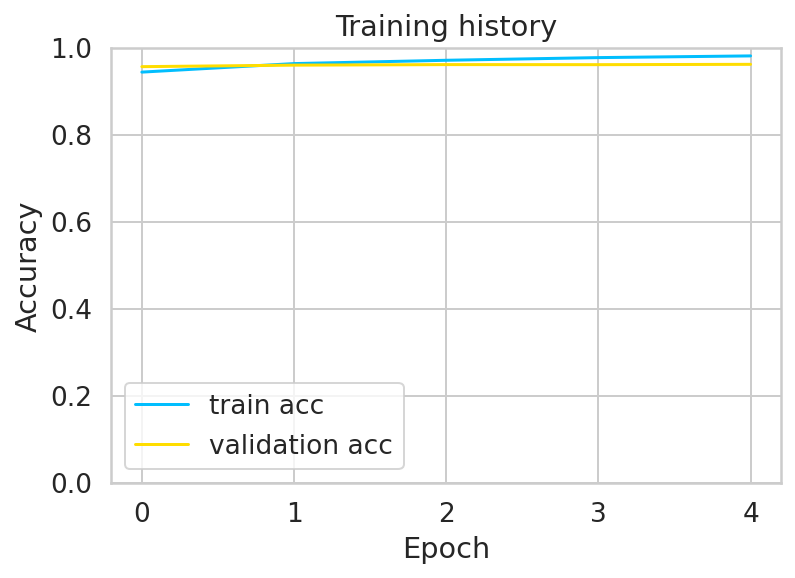

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Lets calculate score on test data

test_acc, _ = eval_model(model, test_data_loader, device, len(df_test))

print(test_acc)

0.9624842686743365


In [ ]:
# alternative
path1 = "/content/drive/My Drive/NER Training data/best_model_state_f2.bin"

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=20, output_attentions = False, output_hidden_states = False)
model.load_state_dict(torch.load(path1))

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
# Apply model to new sentence

new_sentence = """Show me science fiction films directed by Steven Spielberg"""

In [ ]:
# Tokenizing the sentence
tokenized_sentence = tokenizer.encode(new_sentence)

input_id = torch.tensor([tokenized_sentence]).to(device)

In [ ]:
# Let run sentence through model

with torch.no_grad():
  output = model(input_id)

labels = np.argmax(output[0].to('cpu').numpy(),axis = 2)

In [ ]:
# Now we need to convert back these id's to actual labels

# First lets convert input_id back to actual english sentence

tokens = tokenizer.convert_ids_to_tokens(input_id.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label in zip(tokens, labels[0]):
  if token.startswith('##'):
    new_tokens[-1] =  new_tokens[-1] + token[2:]
  
  else:
    new_labels.append(tag_map_index.get(label))
    new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
  print("{}\t{}".format(label, token))

[CLS]	[CLS]
O	Show
O	me
O	science
O	fiction
O	films
O	directed
O	by
B-per	Steven
I-per	Spielberg
[SEP]	[SEP]


In [ ]:
# function to load data for error analysis

def get_params(sentences_file, labels_file):
    sentences = []
    labels = []

    with open(sentences_file) as f:
        for sentence in f.read().splitlines():
            # # replace each token by its index if it is in vocab
            # # else use index of UNK_WORD
            # s = [vocab[token] if token in vocab 
            #      else vocab['UNK']
            #      for token in sentence.split(' ')]
            sentences.append(sentence)

    with open(labels_file) as f:
        for label in f.read().splitlines():
            # # replace each label by its index
            # l = [tag_map[label] for label in sentence.split(' ')] # I added plus 1 here
            labels.append(label) 
    return sentences, labels, len(sentences)

path1 = "/content/drive/My Drive/NER Validation data/sentences.txt"
path2 = "/content/drive/My Drive/NER Validation data/labels.txt"

valid_sentences, valid_labels, valid_len = get_params(path1,path2)

for i in valid_labels:
  

In [ ]:
# Error analysis on validation data

print(' '.join(valid_sentences[0][1:-1]))
print(valid_labels[0][1:-1])

# Tokenizing the sentence
tokenized_sentence = tokenizer.convert_tokens_to_ids(valid_sentences[0])

input_id = torch.tensor([tokenized_sentence]).to(device)

# Let run sentence through model

with torch.no_grad():
  output = model(input_id)

labels = np.argmax(output[0].to('cpu').numpy(),axis = 2)

# Now we need to convert back these id's to actual labels

# First lets convert input_id back to actual english sentence

tokens = tokenizer.convert_ids_to_tokens(input_id.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label in zip(tokens, labels[0]):
  if token == '[CLS]' or token == '[SEP]':
			continue
  if token.startswith('##'):
    new_tokens[-1] =  new_tokens[-1] + token[2:]
  
  else:
    new_labels.append(tag_map_index.get(label))
    new_tokens.append(token)

print(new_labels)

Russia ' s victory put the eight - time Olympic champions into the quarterfinals and also clinched a spot for Sweden .
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O']
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O']


In [ ]:
# Error analysis on validation data

print(valid_sentences[0])
print(valid_labels[0].split(' '))

# Tokenizing the sentence
tokenized_sentence = tokenizer.convert_tokens_to_ids(valid_sentences[0])

input_id = torch.tensor([tokenized_sentence]).to(device)

# Let run sentence through model

with torch.no_grad():
  output = model(input_id)

labels = np.argmax(output[0].to('cpu').numpy(),axis = 2)

# Now we need to convert back these id's to actual labels

# First lets convert input_id back to actual english sentence

tokens = tokenizer.convert_ids_to_tokens(input_id.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label in zip(tokens, labels[0]):
  if token == '[CLS]' or token == '[SEP]':
			continue
  if token.startswith('##'):
    new_tokens[-1] =  new_tokens[-1] + token[2:]
  
  else:
    new_labels.append(tag_map_index.get(label))
    new_tokens.append(token)

print(new_labels)

Russia 's victory put the eight-time Olympic champions into the quarterfinals and also clinched a spot for Sweden .
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O']
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O']


In [ ]:
valid_labels[0]

'B-geo O O O O O O O O O O O O O O O O B-org O'

In [ ]:
tokenizer.convert_tokens_to_ids(valid_sentences[0])

[101,
 2733,
 112,
 188,
 2681,
 1508,
 1103,
 2022,
 118,
 1159,
 3557,
 5461,
 1154,
 1103,
 15388,
 1105,
 1145,
 23782,
 170,
 3205,
 1111,
 3865,
 119,
 102]

In [ ]:
'Russia'.upper()

'RUSSIA'